In [2]:
import pandas as pd
from datetime import datetime, timedelta

start_date = datetime(2019, 1, 1)
end_date = datetime(2022, 12, 31)

date_range = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]

unique_yyyymm_values = sorted(list(set(date.strftime('%Y%m') for date in date_range)))


for i in unique_yyyymm_values:
    variable_name = f"df_{i}"
    globals()[variable_name] = pd.read_csv(f'../Data/{i}-capitalbikeshare-tripdata.csv')

C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_13576\1052836543.py:14: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  globals()[variable_name] = pd.read_csv(f'../Data/{i}-capitalbikeshare-tripdata.csv')


In [27]:
result_list = []

for i in unique_yyyymm_values:
    df_name = f'df_{i}'
    columns_len = len(locals()[df_name].columns)
    result_list.append(columns_len)

set(result_list)

{9, 13}

In [4]:
# Match column names for all datasets and drop na values
for i in unique_yyyymm_values:
    variable_name = f"df_{i}"
    if len(globals()[variable_name].columns) == 9:
        globals()[variable_name].rename(columns={
            'Duration':'Duration', 
            'Start date':'started_at', 
            'End date':'ended_at',
            'Start station number':'start_station_id',
            'Start station':'start_station_name', 
            'End station number':'end_station_id', 
            'End station':'end_station_name', 
            'Bike number':'Bike number',
            'Member type':'member_casual'
        }, inplace=True)
    else:
        pass
    globals()[variable_name].dropna()

In [6]:
merge_df = df_201901.copy()

for i in unique_yyyymm_values[1:]:
    variable_name = f"df_{i}"
    merge_df = pd.concat([merge_df,globals()[variable_name]],ignore_index=True, sort=False)

In [7]:
merge_df.shape

(11841994, 15)

In [8]:
# Add duration in seconds
merge_df['ended_at'] = pd.to_datetime(merge_df['ended_at'])
merge_df['started_at'] = pd.to_datetime(merge_df['started_at'])
merge_df['Duration'] = merge_df['ended_at']-merge_df['started_at']
merge_df['Duration'] = merge_df['Duration'].dt.total_seconds()

# Add Year/Month/Day column
merge_df['Year'] = merge_df['started_at'].dt.year
merge_df['Month'] = merge_df['started_at'].dt.month
merge_df['Day'] = merge_df['started_at'].dt.day

# Change member column to lower case to unify format
merge_df.member_casual = merge_df.member_casual.str.lower()

# Eliminate Duration less than 0
merge_df = merge_df[~(merge_df['Duration'] < 0)]

In [9]:
# starting IDs that can't be matched
start_empty = merge_df[merge_df.start_lat.isna() | merge_df.start_lng.isna()]
start_not_empty = merge_df[merge_df.start_lat.notna() & merge_df.start_lng.notna()]

start_a = set(start_empty.start_station_id)
start_b = set(start_not_empty.start_station_id)

# ending IDs that can't be matched
end_empty = merge_df[merge_df.end_lat.isna() | merge_df.end_lng.isna()]
end_not_empty = merge_df[merge_df.end_lat.notna() & merge_df.end_lng.notna()]

end_a = set(end_empty.start_station_id)
end_b = set(end_not_empty.start_station_id)

# Take out stations that don't have a longitude and latitude
merge_df = merge_df[~merge_df['start_station_id'].isin(list((start_a-start_b) | (end_a-end_b)))]

In [10]:
# fill in station latitude longitude missing values for 2019

station_index = merge_df[merge_df.start_lat.notna()].groupby('start_station_id')[['start_lat','start_lng']].first().reset_index()

merge_df['start_lat'] = merge_df['start_lat'].fillna(merge_df['start_station_id'].map(station_index.set_index('start_station_id')['start_lat']))
merge_df['start_lng'] = merge_df['start_lng'].fillna(merge_df['start_station_id'].map(station_index.set_index('start_station_id')['start_lng']))
merge_df['end_lat'] = merge_df['end_lat'].fillna(merge_df['end_station_id'].map(station_index.set_index('start_station_id')['start_lat']))
merge_df['end_lng'] = merge_df['end_lng'].fillna(merge_df['end_station_id'].map(station_index.set_index('start_station_id')['start_lng']))


In [11]:
a = merge_df.groupby(['Year','Month','Day']).agg({'Duration':'mean'}).reset_index()
print(len(a[a['Year']==2019]))
print(len(a[a['Year']==2020]))
print(len(a[a['Year']==2021]))
print(len(a[a['Year']==2022]))

365
366
365
365


In [31]:
import pandas as pd
from scipy.stats import chi2_contingency

cross_tab = pd.crosstab(index=merge_df['Year'], columns=merge_df['member_casual'])

# Performing a chi-square test
chi2, p, dof, expected = chi2_contingency(cross_tab)

# Displaying the results
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

Chi-square statistic: 819011.5539439516
P-value: 0.0
Degrees of freedom: 3
Expected frequencies:
[[1095623.02944783 2302044.97055217]
 [ 712430.61071807 1496908.38928193]
 [ 886633.31418511 1862930.68581489]
 [1121095.04564899 2355564.95435101]]


In [12]:
a = merge_df.groupby(['Year','Month']).agg({'Duration':'sum','start_station_id':'count'}).reset_index()
a['mean'] = a.Duration/a.start_station_id
a

Year  Month     Duration  start_station_id         mean
0   2019      1  129523763.0            150752   859.184376
1   2019      2  141732052.0            158119   896.363195
2   2019      3  284333024.0            253781  1120.387358
3   2019      4  433558727.0            347949  1246.041020
4   2019      5  384530115.0            337660  1138.808609
5   2019      6  410681058.0            350107  1173.015844
6   2019      7  418345221.0            356621  1173.080724
7   2019      8  397635043.0            360027  1104.458952
8   2019      9  376307620.0            360209  1044.692442
9   2019     10  333855243.0            337551   989.051263
10  2019     11  192140503.0            223512   859.642896
11  2019     12  133720330.0            161380   828.605341
12  2020      1  161004784.0            196691   818.567113
13  2020      2  146992372.0            177901   826.259391
14  2020      3  185199461.0            162530  1139.478625
15  2020      4  477880669.0             75471  6331.977435
16  2020      5  715233153.0            148482  4816.968744
17  2020      6  870969159.0            213289  4083.516539
18  2020      7  756550173.0            223525  3384.633365
19  2020      8  836879960.0            234409  3570.169917
20  2020      9  616109148.0            228547  2695.765632
21  2020     10  504579958.0            209970  2403.105005
22  2020     11  307925227.0            159714  1927.978931
23  2020     12  136314998.0             94262  1446.128854
24  2021      1  134473145.0             89960  1494.810416
25  2021      2   91160726.0             69158  1318.151566
26  2021      3  289942480.0            155946  1859.249227
27  2021      4  379893442.0            196394  1934.343422
28  2021      5  412910190.0            230339  1792.619530
29  2021      6  459413990.0            250825  1831.611642
30  2021      7  525890117.0            290609  1809.614007
31  2021      8  374489162.0            254026  1474.215876
32  2021      9  412800017.0            291954  1413.921429
33  2021     10  520346687.0            312865  1663.166820
34  2021     11  311655723.0            230466  1352.285036
35  2021     12  219813315.0            180746  1216.144839
36  2022      1  108998316.0            103710  1050.991380
37  2022      2  164986618.0            147544  1118.219772
38  2022      3  386708506.0            243994  1584.909899
39  2022      4  476768913.0            296768  1606.537474
40  2022      5  490375267.0            319063  1536.923012
41  2022      6  627896332.0            373683  1680.291402
42  2022      7  629677521.0            378887  1661.913766
43  2022      8  564446681.0            363940  1550.933343
44  2022      9  527616051.0            373132  1414.019840
45  2022     10  456433522.0            321706  1418.790828
46  2022     11  332382381.0            248473  1337.700197
47  2022     12  190510196.0            165994  1147.693266

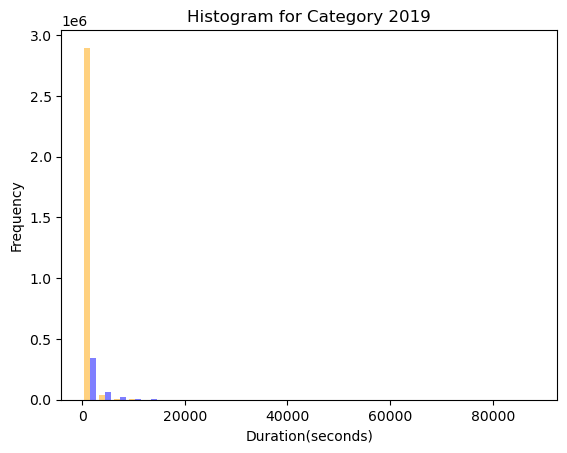

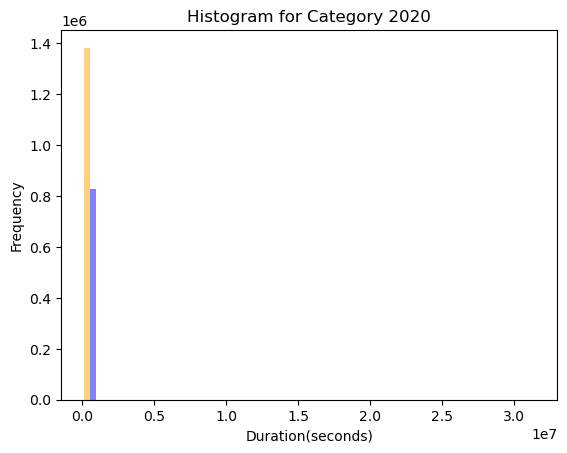

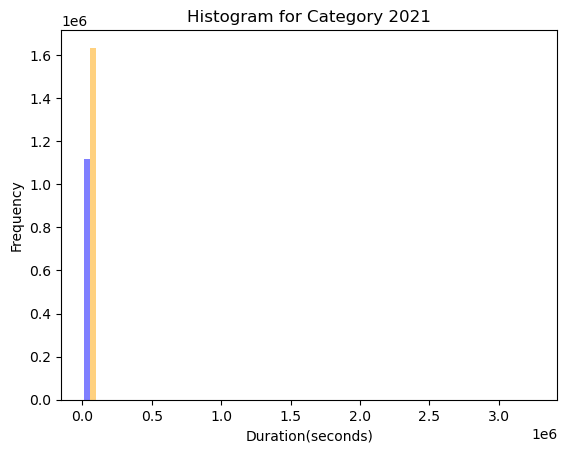

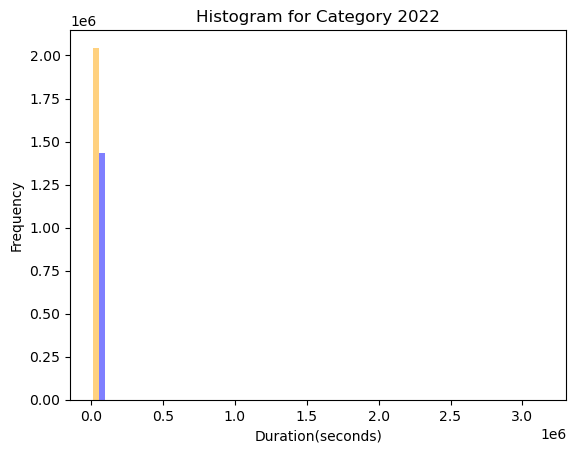

In [13]:
import matplotlib.pyplot as plt

colors = {'member': 'orange', 'casual': 'blue'}

for category in merge_df.Year.unique():
    plt.figure()  # Create a new figure for each category
    subset_df = merge_df[merge_df['Year'] == category]
    # plt.hist(subset_df['Duration'], bins=5, color='skyblue', edgecolor='black')

    unique_categories = subset_df['member_casual'].unique()
    plt.hist([subset_df[subset_df['member_casual'] == cat]['Duration'] for cat in unique_categories],
         bins=30, alpha=0.5, color=[colors[cat] for cat in unique_categories], label=colors.keys())
    plt.xlabel('Duration(seconds)')
    plt.ylabel('Frequency')
    plt.title(f'Histogram for Category {category}')

In [14]:
# Remove Outliers
Q1 = merge_df['Duration'].quantile(0.25)
Q3 = merge_df['Duration'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_no_outliers = merge_df[(merge_df['Duration'] >= lower_bound) & (merge_df['Duration'] <= upper_bound)]
df_outliers = merge_df[(merge_df['Duration'] < lower_bound) | (merge_df['Duration'] > upper_bound)]

In [15]:
df_no_outliers.groupby(['Year','Month']).agg({'Duration':'mean','start_station_id':'count'})

Duration  start_station_id
Year Month                               
2019 1       650.219638            146054
     2       678.588181            152936
     3       754.080555            237118
     4       817.144919            318834
     5       798.601590            315549
     6       808.646014            325699
     7       803.536757            330872
     8       791.788993            337217
     9       778.985618            341396
     10      756.953272            322545
     11      697.190769            216670
     12      674.261651            156896
2020 1       676.610990            191823
     2       678.409969            173145
     3       803.661988            150699
     4       943.697343             64621
     5      1022.489124            118653
     6       990.328315            177680
     7       917.917783            194747
     8       909.713372            204251
     9       881.776801            202283
     10      854.251888            189051
     11      845.551687            143495
     12      767.148500             87825
2021 1       764.750747             83099
     2       742.030472             65491
     3       851.236648            138244
     4       853.462600            172788
     5       843.668697            206973
     6       833.980395            226887
     7       842.259990            260751
     8       820.160460            233604
     9       818.606580            270022
     10      820.717890            285553
     11      762.012371            216308
     12      737.246021            170029
2022 1       659.491066            100051
     2       705.525746            140072
     3       803.139048            220787
     4       825.444316            265992
     5       825.045053            288690
     6       833.256183            337618
     7       824.264781            340088
     8       807.509728            330379
     9       797.637079            345047
     10      775.305283            298023
     11      743.525079            232269
     12      693.425779            158332

In [71]:
df_no_outliers.tail()

Duration          started_at            ended_at start_station_id  \
11841989     617.0 2022-12-29 11:50:13 2022-12-29 12:00:30          31600.0   
11841990     485.0 2022-12-05 19:14:05 2022-12-05 19:22:10          31600.0   
11841991     278.0 2022-12-05 12:51:38 2022-12-05 12:56:16          31600.0   
11841992     438.0 2022-12-09 17:07:36 2022-12-09 17:14:54          31600.0   
11841993     244.0 2022-12-31 13:11:35 2022-12-31 13:15:39          32415.0   

         start_station_name end_station_id          end_station_name  \
11841989      5th & K St NW        31655.0  New Jersey Ave & F St NW   
11841990      5th & K St NW        31655.0  New Jersey Ave & F St NW   
11841991      5th & K St NW        31655.0  New Jersey Ave & F St NW   
11841992      5th & K St NW        31655.0  New Jersey Ave & F St NW   
11841993     Tanger Outlets        32407.0     Oxon Hill Park & Ride   

         Bike number member_casual           ride_id  rideable_type  \
11841989         NaN        member  99A72D09AA13F4F9   classic_bike   
11841990         NaN        casual  12E5CC8D2DAE1507   classic_bike   
11841991         NaN        casual  207B3857E702843E  electric_bike   
11841992         NaN        member  DC8A0AA7E8375123   classic_bike   
11841993         NaN        member  7C0F89F62865282A   classic_bike   

          start_lat  start_lng    end_lat    end_lng  Year  Month  Day  
11841989  38.903040 -77.019027  38.897108 -77.011616  2022     12   29  
11841990  38.903040 -77.019027  38.897108 -77.011616  2022     12    5  
11841991  38.903068 -77.018793  38.897108 -77.011616  2022     12    5  
11841992  38.903040 -77.019027  38.897108 -77.011616  2022     12    9  
11841993  38.796800 -77.002600  38.798749 -77.001030  2022     12   31

C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_13576\4073051603.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Month', y='Duration', hue='Year', data=df_no_outliers, estimator=sum, ci=None)


<Axes: xlabel='Month', ylabel='Duration'>

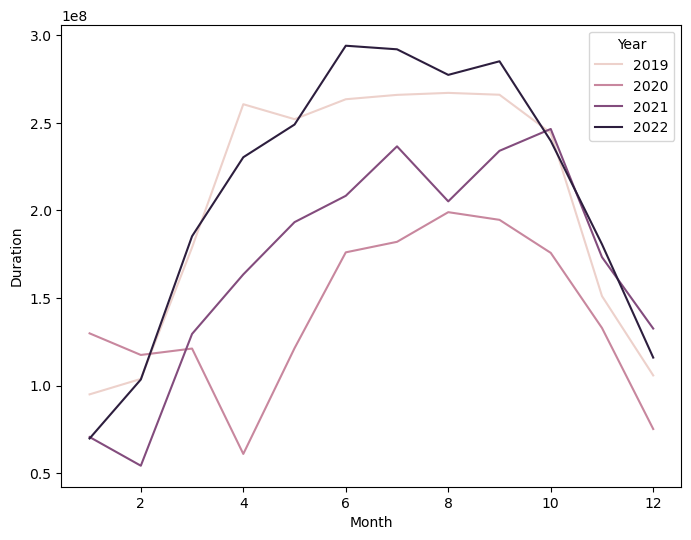

In [76]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.lineplot(x='Month', y='Duration', hue='Year', data=df_no_outliers, estimator=sum, ci=None)

C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_13576\3586413024.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Month', y='Duration', hue='Year', data=df_no_outliers, estimator=sum, ci=None)


<Axes: xlabel='Month', ylabel='Duration'>

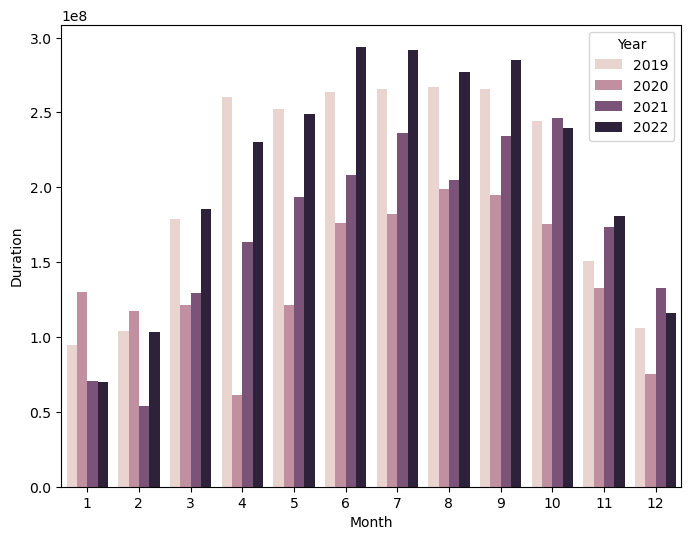

In [75]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.barplot(x='Month', y='Duration', hue='Year', data=df_no_outliers, estimator=sum, ci=None)

C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_13576\2832672741.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Month', y='Duration', hue='Year', data=df_no_outliers, estimator=np.mean, ci=None)


<Axes: xlabel='Month', ylabel='Duration'>

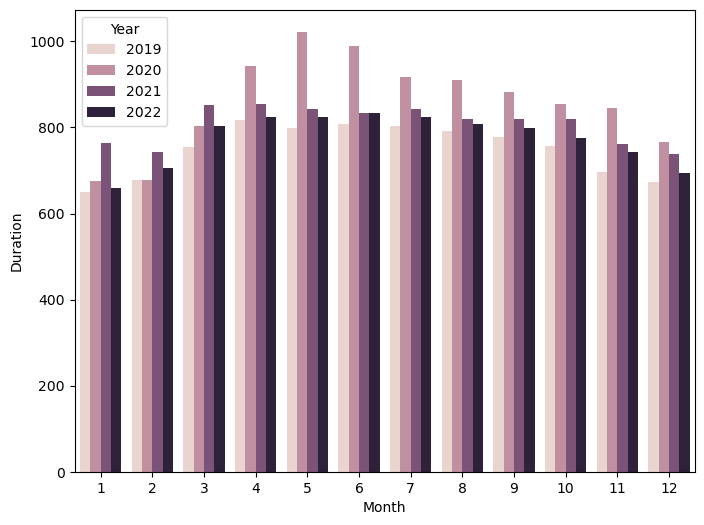

In [74]:
import seaborn as sns
from scipy.stats.mstats import gmean
import numpy as np

plt.figure(figsize=(8, 6))
sns.barplot(x='Month', y='Duration', hue='Year', data=df_no_outliers, estimator=np.mean, ci=None)

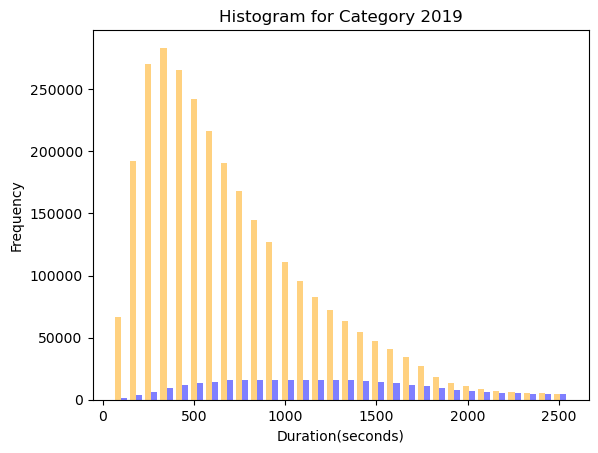

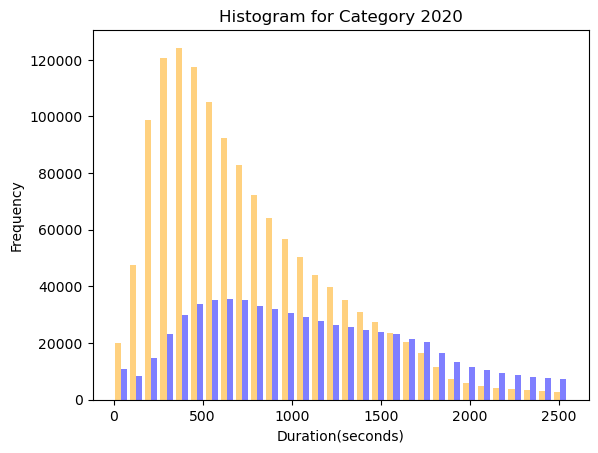

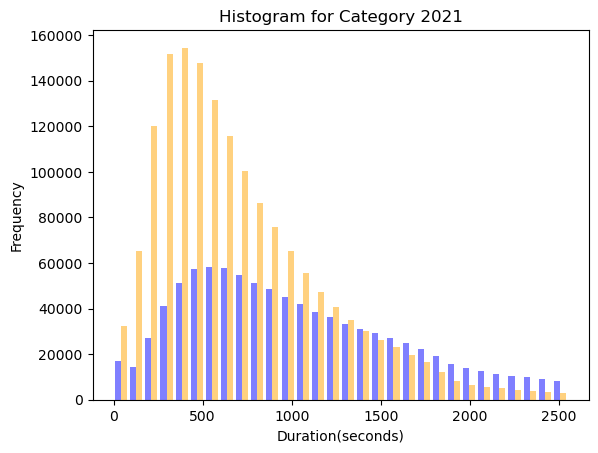

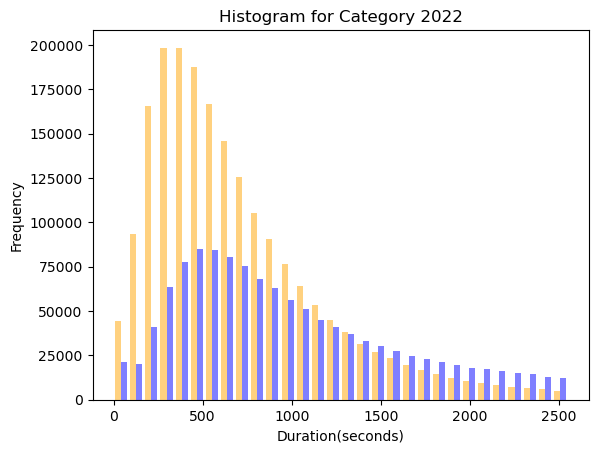

In [16]:
import matplotlib.pyplot as plt

colors = {'member': 'orange', 'casual': 'blue'}

for category in merge_df.Year.unique():
    plt.figure()  # Create a new figure for each category
    subset_df = df_no_outliers[df_no_outliers['Year'] == category]
    # plt.hist(subset_df['Duration'], bins=5, color='skyblue', edgecolor='black')
    
    unique_categories = subset_df['member_casual'].unique()
    plt.hist([subset_df[subset_df['member_casual'] == cat]['Duration'] for cat in unique_categories],
         bins=30, alpha=0.5, color=[colors[cat] for cat in unique_categories], label=colors.keys())

    plt.xlabel('Duration(seconds)')
    plt.ylabel('Frequency')
    plt.title(f'Histogram for Category {category}')

In [17]:
subset_df = df_no_outliers[df_no_outliers['Year'] == 2021]
subset_df.groupby(['member_casual']).agg({'Duration':'mean','start_station_id':'count'}).reset_index()

member_casual     Duration  start_station_id
0        casual  1005.186025            830976
1        member   705.164260           1498773

In [18]:
id_count = merge_df.groupby(['Year','start_station_id']).size().reset_index(name='Count')

map_df = pd.merge(id_count, station_index, on='start_station_id')
map_df.head()

Year start_station_id  Count  start_lat  start_lng
0  2019          31000.0   1563  38.858971  -77.05323
1  2020          31000.0   1327  38.858971  -77.05323
2  2021          31000.0   1520  38.858971  -77.05323
3  2022          31000.0   2630  38.858971  -77.05323
4  2019          31001.0   1993  38.857250  -77.05332

In [19]:
import folium
from IPython.display import display

for i in list(map_df.Year.unique()):
    subset_df = map_df[map_df['Year'] == i]

    latitudes = list(subset_df['start_lat'])
    longitudes = list(subset_df['start_lng'])
    size = list(subset_df['Count'])

    # Create a folium map centered at the average location
    map_center = [sum(latitudes) / len(latitudes), sum(longitudes) / len(longitudes)]
    my_map = folium.Map(location=map_center, zoom_start=12.5)

    # Add markers for latitude and longitude points
    for lat, lon, size in zip(latitudes, longitudes, size):
        folium.CircleMarker(location=[lat, lon], radius=size / 2000, popup=f"Lat: {lat}, Lon: {lon}", fill=True).add_to(my_map)

    # Display the map
    display(my_map)
